In [1]:
import tfr_evaluate
import util
import glob
from tqdm import tqdm
import numpy as np
import pandas as pd
import embed
import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
run_path = glob.glob('paper_runs/basenji/*/*c7k7jwqa')[0]
model, bin_size = tfr_evaluate.read_model(run_path)
testset, targets = tfr_evaluate.collect_whole_testset(coords=True)
_,np_x, np_y = util.convert_tfr_to_np(testset, 3)

In [3]:
%%time
test_range = range(25)
pr_filename = 'pr_df.csv'
pos_filename = 'pos_df.csv'
if os.path.isfile(pr_filename) and os.path.isfile(pos_filename):
    pr_df = pd.read_csv(pr_filename, index_col='Unnamed: 0')
    pos_df = pd.read_csv(pos_filename, index_col='Unnamed: 0')
else:
    thresh_pr_dict = {}
    thresh_pos_dict = {}
    
    for thresh in tqdm(test_range):
        bool_mask = np_y.max(axis=1)>thresh # above threshold in any 1 cell_line
        thresh_inds = np.unique(np.argwhere(bool_mask).flatten())
        filtered_y = np_y[thresh_inds,:,:]

        filtered_x = np_x[thresh_inds,:,:]    
        N_seqs = thresh_inds.shape[0]
        binned_y = filtered_y.reshape(N_seqs, 2048//bin_size, bin_size, len(targets)).mean(axis=2)
        all_preds = embed.predict_np(filtered_x, model, batch_size=256, reshape_to_2D=False)
        thresh_pr_dict[thresh] = metrics.get_correlation_per_seq(binned_y, all_preds)
        thresh_pos_dict[thresh] = (filtered_y.max(axis=1)>thresh).sum(axis=0)
    pr_df = pd.DataFrame(thresh_pr_dict).T
    pos_df = pd.DataFrame(thresh_pos_dict).T
    pr_df.to_csv(pr_filename)
    pos_df.to_csv(pos_filename)

CPU times: user 8.91 ms, sys: 126 µs, total: 9.04 ms
Wall time: 7.44 ms


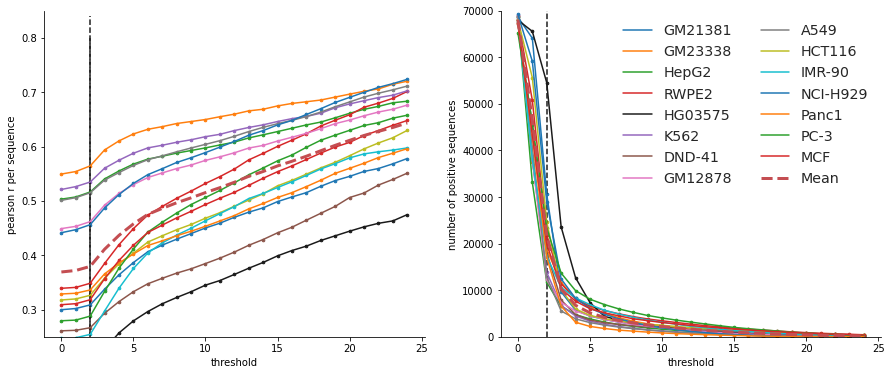

In [4]:
fig, axs = plt.subplots(1,2, figsize=[15,6])
sns.set(font_scale=1.3)  # crazy big
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 9
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 9
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
sns.set_palette('hls', 15)
for cell_line in range(15):
    for d,df in enumerate([pr_df, pos_df]):
        if cell_line == 4:
            axs[d].plot(test_range, df.iloc[:,cell_line], label = targets[cell_line], c='k')
            axs[d].scatter(test_range, df.iloc[:,cell_line], c='k', s=7)
        else:
            axs[d].plot(test_range, df.iloc[:,cell_line], label = targets[cell_line])
            axs[d].scatter(test_range, df.iloc[:,cell_line], s=7)
axs[0].plot(test_range, pr_df.mean(axis=1), linewidth=3, linestyle='--', color='r', label='Mean')
axs[1].plot(test_range, pos_df.mean(axis=1), linewidth=3, linestyle='--', color='r', label='Mean')
axs[0].vlines(2, 0,0.8, linestyles='--',colors ='k')
axs[0].vlines(2, axs[0].get_ylim()[0], axs[0].get_ylim()[1], linestyles='--',colors ='k')
axs[1].vlines(2, axs[1].get_ylim()[0], axs[1].get_ylim()[1], linestyles='--',colors ='k')
axs[0].set_ylim(0.25,0.85)
axs[1].set_ylim(0,70000)
axs[1].legend(loc="upper right", bbox_to_anchor=(1,1), ncol=2,frameon=False)
axs[0].set_xlabel('threshold')
axs[1].set_xlabel('threshold')
axs[0].set_ylabel('pearson r per sequence')
axs[1].set_ylabel('number of positive sequences')
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
# axs[0].set_xticks(range(0,n_points,4));
# axs[1].set_xticks(range(0,n_points,4));
plt.savefig('thresh_vs_perf_2.svg', bbox_inches='tight')

In [24]:
pr_df.mean(axis=1)

0     0.369249
1     0.372016
2     0.379503
3     0.411106
4     0.436664
5     0.457713
6     0.475247
7     0.486195
8     0.496590
9     0.505619
10    0.515316
11    0.524325
12    0.534272
13    0.545236
14    0.554088
15    0.564360
16    0.572911
17    0.582193
18    0.592255
19    0.602203
20    0.611380
21    0.620340
22    0.627839
23    0.635091
24    0.643404
dtype: float64

In [7]:
# add peak centered dataset performance

# check performance for peak-centered dataset
# load dataset
testset, targets = tfr_evaluate.collect_whole_testset(data_dir='/mnt/1a18a49e-9a31-4dbf-accd-3fb8abbfab2d/shush/4grid_atac/complete/peak_centered/i_2048_w_1/', 
                                         coords=False, batch_size=512)



In [12]:
np_x, np_y = util.convert_tfr_to_np(testset, 2)

In [16]:
N_seqs = np_y.shape[0]

In [18]:
binned_y = np_y.reshape(N_seqs, 2048//bin_size, bin_size, len(targets)).mean(axis=2)

In [19]:
all_preds = embed.predict_np(np_x, model, batch_size=256, reshape_to_2D=False)

In [20]:
all_preds.shape

(12054, 2048, 15)

In [21]:
peak_centered_perf = metrics.get_correlation_per_seq(binned_y, all_preds)

/home/shush/tf_2/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [23]:
np.mean(peak_centered_perf)

0.5256227238853803